# Tutorial on **Image Regression Using Dino-v3**

## Setup and Imports

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
VAL_SUBSET_SIZE = 500 # subset size for quick evaluation
EPOCHS = 5
LEARNING_RATE = 1e-3
NUM_WORKERS = 2
RANDOM_SEED = 42
IMAGE_SIZE = 224 # 224 is typical for vit / dinov3
BACKBONE_NAME = 'vit_base_patch16_dinov3'

## Accessing Local Dataset

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Dinov3Data/Images"
CSV_PATH = "/content/drive/MyDrive/Dinov3Data/human_count_rgb.csv"
OUTPUT_DIR = "/content/drive/MyDrive/DinoV3Data/Results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
def set_seed(seed=RANDOM_SEED):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed()

## Preprocessing Dataset

In [ ]:
class ImageRegressionDataset(Dataset):
  def __init__(self, csv_path, image_dir, transform=None):
    self.df = pd.read_csv(csv_path)
    assert 'filename' in self.df.columns and 'num_humans' in self.df.columns, \
    "CSV must have 'filename' and 'num_humans' columns"
    self.image_dir = image_dir
    self.transform = transform


  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_path = os.path.join(self.image_dir, str(row['filename']).strip())
    if not os.path.exists(img_path):
      # try with extension if missing
      for ext in ('.jpg','.jpeg','.png'):
        alt = img_path + ext
        if os.path.exists(alt):
          img_path = alt
          break
    img = Image.open(img_path).convert('RGB')
    if self.transform:
      img = self.transform(img)
    target = torch.tensor(float(row['num_humans']), dtype=torch.float32)
    return img, target

In [ ]:
transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225])
])


# load dataset
dataset = ImageRegressionDataset(CSV_PATH, IMAGE_DIR, transform=transform)


# Split into train and val (80/20)
n = len(dataset)
indices = list(range(n))
random.shuffle(indices)
split = int(0.8 * n)
train_indices, val_indices = indices[:split], indices[split:]
train_ds = Subset(dataset, train_indices)
val_ds = Subset(dataset, val_indices)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
val_subset_size = min(VAL_SUBSET_SIZE, len(val_ds))
val_subset_indices = np.random.choice(len(val_ds), val_subset_size, replace=False)
val_subset = Subset(val_ds, val_subset_indices)
val_subset_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Showing sample images from training set:


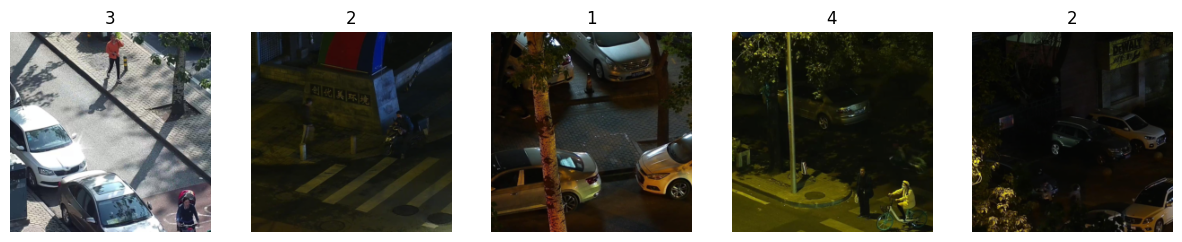

In [ ]:
def show_samples(dataset, num=5):
  fig, axes = plt.subplots(1, num, figsize=(3*num, 3))
  chosen = np.random.choice(len(dataset), num, replace=False)
  for ax, i in zip(axes, chosen):
    img, target = dataset[i]
    # unnormalize for display
    img_np = img.permute(1,2,0).numpy()
    img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]), 0, 1)
    ax.imshow(img_np)
    ax.set_title(f"{int(target.item()):}")
    ax.axis('off')
  plt.show()


print('Showing sample images from training set:')
show_samples(train_ds, num=5)

## Fine-tuning & Evaluation

In [ ]:
class DinoRegressor(nn.Module):
  def __init__(self, backbone_name=BACKBONE_NAME, pretrained=True, freeze_backbone=True):
    super().__init__()
    self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')
    feat_dim = self.backbone.num_features
    self.head = nn.Sequential(
      nn.Linear(feat_dim, 256),
      nn.ReLU(inplace=True),
      nn.Linear(256, 1)
      )
    if freeze_backbone:
      for p in self.backbone.parameters():
        p.requires_grad = False


  def forward(self, x):
    feats = self.backbone(x)
    out = self.head(feats)
    return out.squeeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DinoRegressor(freeze_backbone=True).to(device)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
print('Model created. Trainable params:')
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"{trainable} / {total} parameters are trainable")

Model created. Trainable params:
197121 / 85838337 parameters are trainable


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


def predict_on_loader(model, loader):
  model.eval()
  preds, targets = [], []
  with torch.no_grad():
    for imgs, t in loader:
      imgs = imgs.to(device)
      out = model(imgs)
      preds.extend(out.cpu().numpy())
      targets.extend(t.numpy())
  return np.array(preds), np.array(targets)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)


for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0
  progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=False, mininterval=1.0)
  for imgs, t in progress_bar:
    imgs = imgs.to(device)
    t = t.to(device)
    optimizer.zero_grad()
    out = model(imgs)
    loss = criterion(out, t)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
  avg_loss = running_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{EPOCHS}] - Avg Loss: {avg_loss:.4f}")


  preds_val, targets_val = predict_on_loader(model, val_subset_loader)
  mse = mean_squared_error(targets_val, preds_val)
  r2 = r2_score(targets_val, preds_val)
  print(f" Val MSE: {mse:.4f}, R2: {r2:.4f}")

Epoch [1/5] - Avg Loss: 9.8588


 Val MSE: 6.4090, R2: 0.2306


Epoch [2/5] - Avg Loss: 6.3135


 Val MSE: 5.3002, R2: 0.3637


Epoch [3/5] - Avg Loss: 5.4489


 Val MSE: 4.7774, R2: 0.4265


Epoch [4/5] - Avg Loss: 4.6809


 Val MSE: 4.2804, R2: 0.4862


Epoch [5/5] - Avg Loss: 4.0253


 Val MSE: 4.0472, R2: 0.5142


Final MSE on val subset: 4.0472


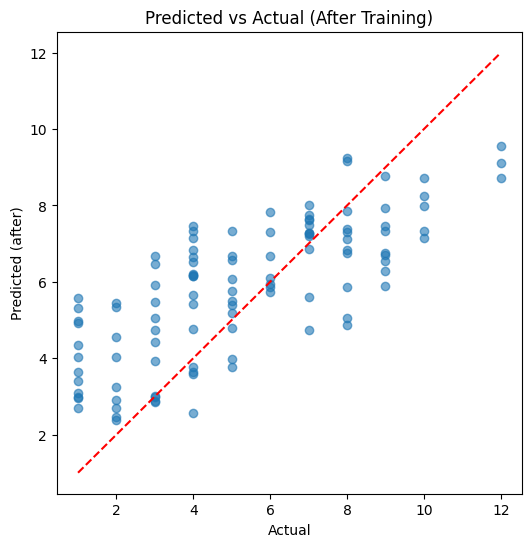

In [ ]:
preds_after, targets_after = predict_on_loader(model, val_subset_loader)
print(f"Final MSE on val subset: {mean_squared_error(targets_after, preds_after):.4f}")


plt.figure(figsize=(6,6))
plt.scatter(targets_after, preds_after, alpha=0.6)
plt.plot([targets_after.min(), targets_after.max()], [targets_after.min(), targets_after.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted (after)')
plt.title('Predicted vs Actual (After Training)')
plt.show()

In [ ]:
def show_predictions(dataset_subset, model, num=5):
  model.eval()
  chosen = np.random.choice(len(dataset_subset), num, replace=False)
  fig, axes = plt.subplots(1, num, figsize=(3*num, 3))
  with torch.no_grad():
    for ax, idx in zip(axes, chosen):
      img, t = dataset_subset[idx]
      inp = img.unsqueeze(0).to(device)
      pred = model(inp).cpu().item()
      img_np = img.permute(1,2,0).numpy()
      img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]), 0, 1)
      ax.imshow(img_np)
      ax.set_title(f"GT: {t.item():.3f}\nPred: {pred:.3f}")
      ax.axis('off')
  plt.show()

Sample predictions after training:


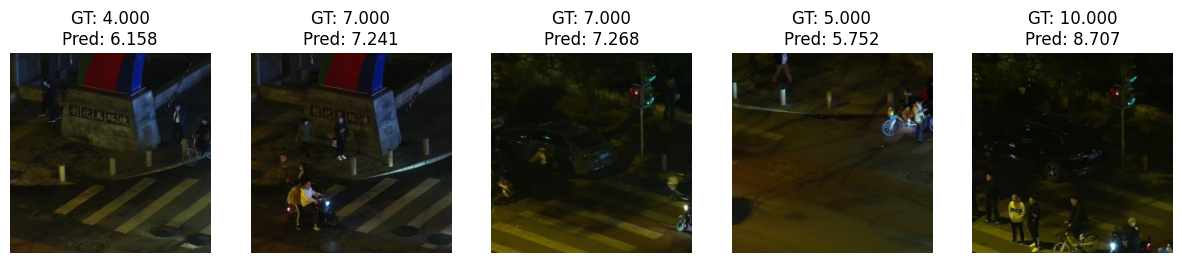

Regression demo complete.


In [ ]:
print('Sample predictions after training:')
show_predictions(val_subset, model, num=5)

print('Regression demo complete.')